# Image segmentation in Cardiac MRI's 

## Imports

In [ ]:
import os
import sys
import azureml.core
from azureml.widgets import RunDetails
from azureml.core.compute import AmlCompute
from sklearn.metrics import confusion_matrix
from azureml.train.automl import AutoMLConfig
from azureml.core.compute import ComputeTarget
from azureml.pipeline.core import PipelineData, TrainingOutput
from azureml.core import Workspace, Run, Experiment, Datastore, Dataset
from azureml.core.runconfig import RunConfiguration, CondaDependencies, DEFAULT_GPU_IMAGE

sys.path.append(os.path.abspath("./utils"))
from attach_compute import get_compute_aml

## Pipeline-specific SDK imports

In [ ]:
from azureml.data.data_reference import DataReference
from azureml.pipeline.core import Pipeline, PipelineData, StepSequence, TrainingOutput
from azureml.pipeline.steps import PythonScriptStep, AutoMLStep
from azureml.pipeline.core import PublishedPipeline
from azureml.pipeline.core.graph import PipelineParameter

print("Pipeline SDK-specific imports completed")

### Initialize Workspace

In [ ]:
ws = Workspace.from_config(path="./settings/config.json")
print(ws.name, ws.resource_group, ws.location, ws.subscription_id, sep = '\n')

### Required data and script files for the the tutorial
Sample files required to finish this tutorial are already copied to the project folder specified above. Even though the .py provided in the samples don't have much "ML work," as a data scientist, you will work on this extensively as part of your work.

### Compute Targets

#### List of Compute Targets on the workspace


In [ ]:
cts = ws.compute_targets
for ct in cts:
    print(ct)

#### Retrieve or create a Azure Machine Learning compute
Azure Machine Learning Compute is a service for provisioning and managing clusters of Azure virtual machines for running machine learning workloads. Let's create a new Azure Machine Learning Compute in the current workspace, if it doesn't already exist. We will then run the training script on this compute target.

If we could not find the compute with the given name in the previous cell, then we will create a new compute here. We will create an Azure Machine Learning Compute containing **STANDARD_D2_V2 CPU VMs**. This process is broken down into the following steps:

1. Create the configuration
2. Create the Azure Machine Learning compute

**This process will take about 3 minutes and is providing only sparse output in the process. Please make sure to wait until the call returns before moving to the next cell.**

In [ ]:
aml_compute_name = "aml-compute"
vm_size = "STANDARD_DS3_V2"
aml_compute = get_compute_aml(ws, aml_compute_name, vm_size)
print("Azure Machine Learning Compute attached")

In [ ]:
run_training_config = RunConfiguration(conda_dependencies=CondaDependencies.create(
        conda_packages=[],
        pip_packages=['azureml-sdk', 'tensorflow-gpu==2.0', 'matplotlib==3.1.3'])
    )
run_training_config.environment.docker.enabled = True

## Creating a Step in a Pipeline
A Step is a unit of execution. Step typically needs a target of execution (compute target), a script to execute, and may require script arguments and inputs, and can produce outputs. The step also could take a number of other parameters. Azure Machine Learning Pipelines provides the following built-in Steps:

- [**PythonScriptStep**](https://docs.microsoft.com/en-us/python/api/azureml-pipeline-steps/azureml.pipeline.steps.python_script_step.pythonscriptstep?view=azure-ml-py): Add a step to run a Python script in a Pipeline.

The following code will create a PythonScriptStep to be executed in the Azure Machine Learning Compute we created above using train.py, one of the files already made available in the project folder.

A **PythonScriptStep** is a basic, built-in step to run a Python Script on a compute target. It takes a script name and optionally other parameters like arguments for the script, compute target, inputs and outputs. If no compute target is specified, default compute target for the workspace is used.

In [ ]:
project_folder = '.'

In [ ]:
training_step = PythonScriptStep(name="Training",
                             script_name="train.py", 
                             compute_target=aml_compute, 
                             source_directory=project_folder,
                             arguments=[
                                  "--model_name", "cardiac_model",
                             ],
                             runconfig=run_training_config,
                             allow_reuse=False)
steps = [training_step]

### Build the pipeline
Once we have the steps (or steps collection), we can build the pipeline.

A pipeline is created with a list of steps and a workspace. Submit a pipeline using [submit](https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.core.experiment%28class%29?view=azure-ml-py#submit). When submit is called, a [PipelineRun](https://docs.microsoft.com/en-us/python/api/azureml-pipeline-core/azureml.pipeline.core.pipelinerun?view=azure-ml-py) is created which in turn creates [StepRun](https://docs.microsoft.com/en-us/python/api/azureml-pipeline-core/azureml.pipeline.core.steprun?view=azure-ml-py) objects for each step in the workflow.

In [ ]:
pipeline = Pipeline(workspace=ws, steps=steps)
print ("Pipeline is built")

### Validate the pipeline
You have the option to [validate](https://docs.microsoft.com/en-us/python/api/azureml-pipeline-core/azureml.pipeline.core.pipeline.pipeline?view=azure-ml-py#validate) the pipeline prior to submitting for run. The platform runs validation steps such as checking for circular dependencies and parameter checks etc. even if you do not explicitly call validate method.

In [ ]:
pipeline.validate()
print("Pipeline validation complete")

### Submit the pipeline
[Submitting](https://docs.microsoft.com/en-us/python/api/azureml-pipeline-core/azureml.pipeline.core.pipeline.pipeline?view=azure-ml-py#submit) the pipeline involves creating an [Experiment](https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.core.experiment?view=azure-ml-py) object and providing the built pipeline for submission. 

In [ ]:
experiment_name = "heart-disease"
pipeline_run = Experiment(ws, experiment_name).submit(pipeline, regenerate_outputs=True)
print("Pipeline is submitted for execution")

In [ ]:
RunDetails(pipeline_run).show()

In [ ]:
pipeline_run.wait_for_completion()
for step_run in pipeline_run.get_children():
    print("{}: {}".format(step_run.name, step_run.get_metrics()))

# Preparing the Data

Before getting to our neural network, we first need to prepare our data. While we're at it, let's load all of the libraries we'll use in this lab.

In [1]:
import datetime
import os

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import (
    Flatten, Dense, Reshape, Conv2D, MaxPool2D, Conv2DTranspose)
import matplotlib.pyplot as plt

plt.rcParams['image.cmap'] = 'Greys_r'

## Making a TensorFlow Dataset

Next, we'll load in our datasets. Since they're already in a TFRecord format, we can supply their path to [`tf.data.TFRecordDataset`](https://www.tensorflow.org/api_docs/python/tf/data/TFRecordDataset). This will load the records into a [tf.dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset), which is TensorFlow's data pipeline tool, designed to ingest large amounts of data locally or from the cloud.

In [2]:
raw_training_dataset = tf.data.TFRecordDataset('data/train_images.tfrecords')
raw_val_dataset      = tf.data.TFRecordDataset('data/val_images.tfrecords')

In order to parse the data, we'll need to provide it's schema. For each feature, we'll define its [class](https://www.tensorflow.org/api_docs/python/tf/io#classes_2) and [data type](https://www.tensorflow.org/api_docs/python/tf/dtypes#other_members). Since our data dimensions are the same for each image, we'll use the [`tf.io.FixedLenFeature`](https://www.tensorflow.org/api_docs/python/tf/io/FixedLenFeature) class.

In [3]:
image_feature_description = {
    'height':    tf.io.FixedLenFeature([], tf.int64),
    'width':     tf.io.FixedLenFeature([], tf.int64),
    'depth':     tf.io.FixedLenFeature([], tf.int64),
    'name' :     tf.io.FixedLenFeature([], tf.string),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
    'label_raw': tf.io.FixedLenFeature([], tf.string),
}

The `image_feature_description` can be used to parse each tfrecord with [`tf.io.parse_single_example`](https://www.tensorflow.org/api_docs/python/tf/io/parse_single_example). Since the records are already in a tf.dataset, we can [map](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) the parsing to each record.

In [4]:
def _parse_image_function(example_proto):
    return tf.io.parse_single_example(example_proto, image_feature_description)

parsed_training_dataset = raw_training_dataset.map(_parse_image_function)
parsed_val_dataset      = raw_val_dataset.map(_parse_image_function)

To verify, let's print the number of elements in our parsed dataset. There should be 234 training images and 26 validation images.

In [5]:
print(len(list(parsed_training_dataset)))
print(len(list(parsed_val_dataset)))

234
26


Right now, our images are in bytes and don't much resemble and image. Let's fix that! We'll make a function, `read_and_decode` that will use [`tf.io.decode_raw`](https://www.tensorflow.org/api_docs/python/tf/io/decode_raw) to convert the bytes into a vector of integers. That's still not quite an image, so [`tf.reshape`](https://www.tensorflow.org/api_docs/python/tf/reshape) is used to make it into a square 256x256x1 array, where each cell represents a greyscale pixel.

Neural networks work better with floats instead of integers, so we'll scale down the images into a 0 to 1 range. We won't do this with the label image, as we'll use the integers there to represent our prediction classes.

In [6]:
@tf.function
def read_and_decode(example):
    image_raw = tf.io.decode_raw(example['image_raw'], tf.int64)
    image_raw.set_shape([65536])
    image = tf.reshape(image_raw, [256, 256, 1])

    image = tf.cast(image, tf.float32) * (1. / 1024)

    label_raw = tf.io.decode_raw(example['label_raw'], tf.uint8)
    label_raw.set_shape([65536])
    label = tf.reshape(label_raw, [256, 256, 1])

    return image, label

We can map this decoding function to each image in our dataset like we did with the parsing function before.

In [7]:
tf_autotune = tf.data.experimental.AUTOTUNE
train = parsed_training_dataset.map(
    read_and_decode, num_parallel_calls=tf_autotune)
val = parsed_val_dataset.map(read_and_decode)
train.element_spec

(TensorSpec(shape=(256, 256, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(256, 256, 1), dtype=tf.uint8, name=None))

A few final things to consider with our dataset. Tf.datasets have a [shuffle](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle) method to take X elements from our dataset and shuffle their order before passing them to the model. This is useful for large datasets that would be impossible to shiffle locally on a machine and critical for multi-worker training to keep the datasets different for each worker.

[batch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch), on the other hand, takes Y elements from the buffer and distributes it to a worker for training.

It's like a deck a cards. A dealer takes X cards off the top of the deck, shuffles them, and deals Y cards to each worker.

There are also a [cache](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache) method to store the processed dataset in memory to speed up training times and a [prefetch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) method that prepares the next batch of data while the current batch is being used for training. A typical pipeline prepares data on the CPU while performing model data on the GPU. For more information on how to optimize a data model, see this article [here](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch).

For the purpose of this project, we'll use a buffer size of 10 and a batch size of 1.

In [8]:
BUFFER_SIZE = 10
BATCH_SIZE = 1

In [9]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf_autotune)
test_dataset  = val.batch(BATCH_SIZE)
train_dataset

<PrefetchDataset shapes: ((None, 256, 256, 1), (None, 256, 256, 1)), types: (tf.float32, tf.uint8)>

## Visualizing the Dataset
Since we're working with images, it would be great if we could compare our input images with our prediction and the true label. While AI eyes have become powerful, human eyes are still useful at detecting anomalies in data and recognizing weaknesses in the AI's predictions. Let's create a function, `display`, to compare our sets of images.

In [10]:
def display(display_list):
    plt.figure(figsize=(10, 10))
    title = ['Input Image', 'Label', 'Predicted Label']

    for i in range(len(display_list)):
        display_resized = tf.reshape(display_list[i], [256, 256])
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(display_resized)
        plt.axis('off')
    plt.show()

Bringing it all together, let's take two batches from our dataset and visualize our input images and segmentation labels.

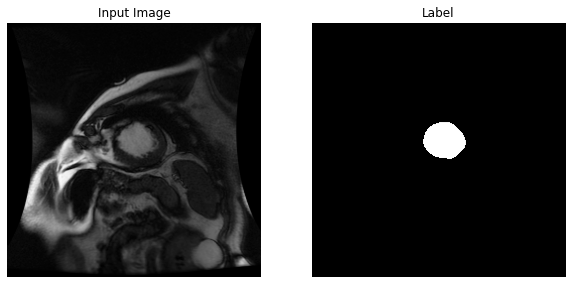

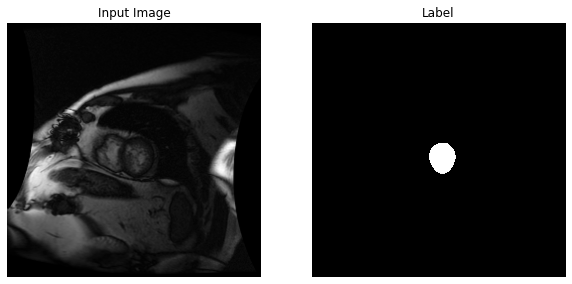

In [11]:
for image, label in train.take(2):
    sample_image, sample_label = image, label
    display([sample_image, sample_label])

If we run the same thing again, we'll get two new sets of images from our dataset.

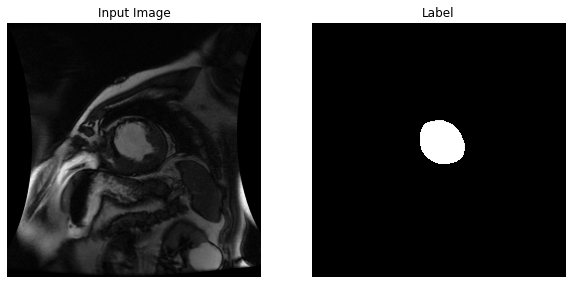

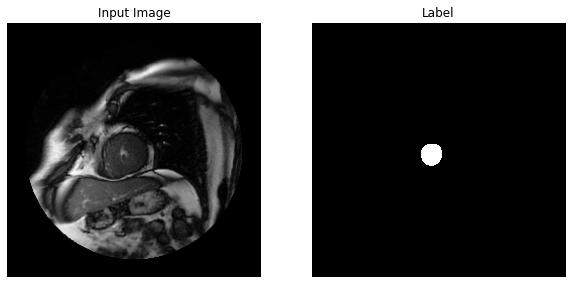

In [12]:
for image, label in val.take(2):
    sample_image, sample_label = image, label
    display([sample_image, sample_label])

Before we get to training, let's build some functions to visualize how the model is learning. First, we'll create a function, `create_mask`, which will take one of our validaiton results and return it as a 256 x 256 x 1 array. Each cell will be either a 1, meaning an LV pixel, or 0, meaning no LV.

We'll do this by using the [`tf.argmax`](https://www.tensorflow.org/api_docs/python/tf/math/argmax) function and observing the last dimension, `axis=-1`. We effectively have an image of 2 channels with the probability of no-LV on the 0th channel and the probability LV on the 1st channel. [`tf.argmax`](https://www.tensorflow.org/api_docs/python/tf/math/argmax) will then return the index of the channel with the higher probability, resulting in a 1 X 256 X 256 array.

In order to get it into the 256 X 256 X 1 shape that our plotting tools expect, we'll append a [new axis](https://www.tensorflow.org/api_docs/python/tf/Tensor) on the end and select the first and only element.

In [26]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

With this, we'll make a function to diplay our predictions, `show_predictions`. If we feed it a dataset, it will display our model predictions on each image in the dataset. Otherwise, it will run our `sample_image` through our model.

In [27]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, label in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], label[0], create_mask(pred_mask)])
    else:
        prediction = create_mask(model.predict(sample_image[tf.newaxis, ...]))
        display([sample_image, sample_label, prediction])

Next, we'll create our own custom [Keras Callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback), so that at the end of each epoch, we'll see what our model predicts on our `sample_image`. We'll also set up a [TensorBoard callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard) so we can graph our training results.

In [28]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

Then, we can run it with `%tensorboard --logdir <log_directory>` where `<log_directory>` is the same log directory defined in `tensorboard_callback`.

TensorBoard can run while models are training as a debugging tool. For instance, if the validation loss starts to increase while the train loss is decreasing, that could be a sign of overfitting and that training should stop to investigate.

We'll leave the above TensorBoard up for the rest of the lab. Check back during other model runs to see how they compare.

So how are our numbers? The accuracy should be over 90%, which sounds great! Let's take a moment to look at some more sample predictions.

## UNET - Convolutional Networks for Biomedical Image Segmentation

### UNET with Dice Metric Loss

![workflow](readme/dice_metric.png)

One metric we can use to more accurately determine how well our network is segmenting LV is called the Dice metric or Sorensen-Dice coefficient, among other names.  This is a metric to compare the similarity of two samples.  In our case we'll use it to compare the two areas of interest, i.e., the area of the expertly-labelled contour and the area of our predicted contour.  The formula for computing the Dice metric is:

$$ \frac{2A_{nl}}{A_{n} + A_{l}} $$

where $A_n$ is the area of the contour predicted by our neural network, $A_l$ is the area of the contour from the expertly-segmented label and $A_{nl}$ is the intersection of the two, i.e., the area of the contour that is predicted correctly by the network.  1.0 means perfect score.

This metric will more accurately inform us of how well our network is segmenting the LV because the class imbalance problem is negated.  Since we're trying to determine how much area is contained in a particular contour, we can simply count the pixels to give us the area.

In [47]:
def dice_coef(y_true, y_pred, smooth=1):
    indices = K.argmax(y_pred, 3)
    indices = K.reshape(indices, [-1, 256, 256, 1])

    true_cast = y_true
    indices_cast = K.cast(indices, dtype='float32')

    axis = [1, 2, 3]
    intersection = K.sum(true_cast * indices_cast, axis=axis)
    union = K.sum(true_cast, axis=axis) + K.sum(indices_cast, axis=axis)
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)

    return dice

def recall(y_true, y_pred):
        y_true = K.ones_like(y_true) 
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        all_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        
        recall = true_positives / (all_positives + K.epsilon())
        return recall


def precision(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))

    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def f1_score(y_true, y_pred):
    precision_score = precision(y_true, y_pred)
    recall_score = recall(y_true, y_pred)
    return 2*((precision_score*recall_score)/(precision_score+recall_score+K.epsilon()))

### UNET Architecture

![UNET architecture](readme/UNET.png)


This task requires you to finish the neural network below and then run the training.  To accomplish this edit the Sequential model and replace all the instances of `FIXME` with code.  There are comments in the code to help you and you can use the following network structure to help as well.  The names of the layers will make more sense as you examine and complete the code.

1. Convolution1, 5 x 5 kernel, stride 2
2. Maxpooling1, 2 x 2 window, stride 2
3. Convolution2, 5 x 5 kernel, stride 2
4. Maxpooling2, 2 x 2 window, stride 2
5. Convolution3, 3 x 3 kernel, stride 1
6. Convolution4, 3 x 3 kernel, stride 1
7. Score_classes, 1x1 kernel, stride 1
8. Upscore (deconvolution), 31 x 31 kernel, stride 16

In [48]:
def get_model():
    layers = [
        Conv2D(input_shape=[256, 256, 1],
            filters=100,
            kernel_size=5,
            strides=2,
            padding="same",
            activation=tf.nn.relu,
            name="Conv1"),
        MaxPool2D(pool_size=2, strides=2, padding="same"),
        Conv2D(filters=200,
            kernel_size=5,
            strides=2,
            padding="same",
            activation=tf.nn.relu),
        MaxPool2D(pool_size=2, strides=2, padding="same"),
        Conv2D(filters=300,
            kernel_size=3,
            strides=1,
            padding="same",
            activation=tf.nn.relu),
        Conv2D(filters=300,
            kernel_size=3,
            strides=1,
            padding="same",
            activation=tf.nn.relu),
        Conv2D(filters=2,
            kernel_size=1,
            strides=1,
            padding="same",
            activation=tf.nn.relu),
        Conv2DTranspose(filters=2, kernel_size=31, strides=16, padding="same")
    ]

    tf.keras.backend.clear_session()
    model = tf.keras.models.Sequential(layers)

    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[dice_coef, 'accuracy', f1_score, precision, recall])

    return model

In [49]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [50]:
model = get_model()

Train for 234 steps
Epoch 1/30
233/234 [============================>.] - ETA: 0s - loss: 0.1149 - dice_coef: 0.0048 - accuracy: 0.9680 - f1_score: 0.9191 - precision: 0.9614 - recall: 0.8899

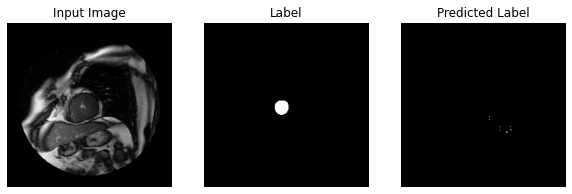


Sample Prediction after epoch 1

234/234 [==============================] - 18s 78ms/step - loss: 0.1147 - dice_coef: 0.0049 - accuracy: 0.9681 - f1_score: 0.9192 - precision: 0.9615 - recall: 0.8899 - val_loss: 0.0598 - val_dice_coef: 0.0140 - val_accuracy: 0.9830 - val_f1_score: 0.9576 - val_precision: 1.0000 - val_recall: 0.9189
Epoch 2/30
23/26 [=========================>....] - ETA: 0s - loss: 0.0394 - dice_coef: 0.0038 - accuracy: 0.9869 - f1_score: 0.9826 - precision: 1.0000 - recall: 0.9658

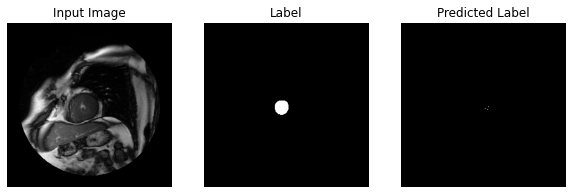


Sample Prediction after epoch 2

234/26 [==============================================================================================================================================================================================================================================================================] - 5s 22ms/step - loss: 0.0477 - dice_coef: 0.0093 - accuracy: 0.9837 - f1_score: 0.9811 - precision: 1.0000 - recall: 0.9630 - val_loss: 0.0377 - val_dice_coef: 0.0243 - val_accuracy: 0.9831 - val_f1_score: 0.9859 - val_precision: 1.0000 - val_recall: 0.9723
Epoch 3/30
24/26 [==========================>...] - ETA: 0s - loss: 0.0303 - dice_coef: 0.0291 - accuracy: 0.9854 - f1_score: 0.9835 - precision: 1.0000 - recall: 0.9677

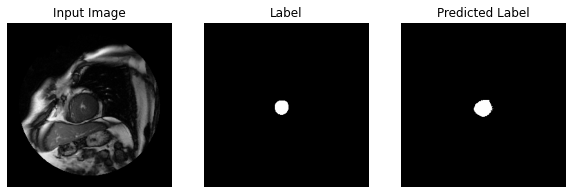


Sample Prediction after epoch 3

234/26 [==============================================================================================================================================================================================================================================================================] - 5s 23ms/step - loss: 0.0198 - dice_coef: 0.4318 - accuracy: 0.9892 - f1_score: 0.9856 - precision: 1.0000 - recall: 0.9717 - val_loss: 0.0241 - val_dice_coef: 0.5896 - val_accuracy: 0.9907 - val_f1_score: 0.9904 - val_precision: 1.0000 - val_recall: 0.9811
Epoch 4/30
24/26 [==========================>...] - ETA: 0s - loss: 0.0186 - dice_coef: 0.5628 - accuracy: 0.9928 - f1_score: 0.9900 - precision: 1.0000 - recall: 0.9802

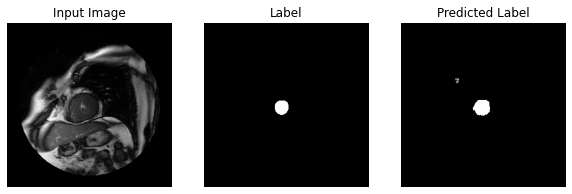


Sample Prediction after epoch 4

234/26 [==============================================================================================================================================================================================================================================================================] - 7s 30ms/step - loss: 0.0124 - dice_coef: 0.6599 - accuracy: 0.9927 - f1_score: 0.9889 - precision: 1.0000 - recall: 0.9781 - val_loss: 0.0183 - val_dice_coef: 0.6722 - val_accuracy: 0.9929 - val_f1_score: 0.9866 - val_precision: 1.0000 - val_recall: 0.9735
Epoch 5/30
23/26 [=========================>....] - ETA: 0s - loss: 0.0147 - dice_coef: 0.6362 - accuracy: 0.9944 - f1_score: 0.9889 - precision: 1.0000 - recall: 0.9782

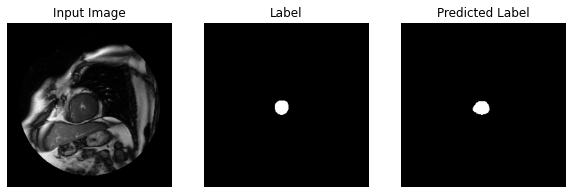


Sample Prediction after epoch 5

234/26 [==============================================================================================================================================================================================================================================================================] - 7s 28ms/step - loss: 0.0177 - dice_coef: 0.7348 - accuracy: 0.9949 - f1_score: 0.9904 - precision: 1.0000 - recall: 0.9810 - val_loss: 0.0185 - val_dice_coef: 0.6775 - val_accuracy: 0.9935 - val_f1_score: 0.9929 - val_precision: 1.0000 - val_recall: 0.9859
Epoch 6/30
25/26 [===========================>..] - ETA: 0s - loss: 0.0135 - dice_coef: 0.6771 - accuracy: 0.9944 - f1_score: 0.9916 - precision: 1.0000 - recall: 0.9833

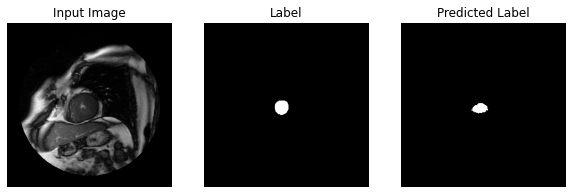


Sample Prediction after epoch 6

234/26 [==============================================================================================================================================================================================================================================================================] - 8s 35ms/step - loss: 0.0099 - dice_coef: 0.7608 - accuracy: 0.9953 - f1_score: 0.9912 - precision: 1.0000 - recall: 0.9826 - val_loss: 0.0152 - val_dice_coef: 0.6965 - val_accuracy: 0.9941 - val_f1_score: 0.9927 - val_precision: 1.0000 - val_recall: 0.9856
Epoch 7/30
25/26 [===========================>..] - ETA: 0s - loss: 0.0105 - dice_coef: 0.7180 - accuracy: 0.9959 - f1_score: 0.9920 - precision: 1.0000 - recall: 0.9840

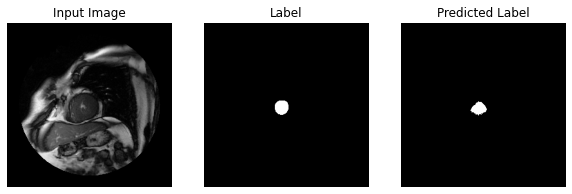


Sample Prediction after epoch 7

234/26 [==============================================================================================================================================================================================================================================================================] - 8s 33ms/step - loss: 0.0075 - dice_coef: 0.7873 - accuracy: 0.9960 - f1_score: 0.9920 - precision: 1.0000 - recall: 0.9841 - val_loss: 0.0122 - val_dice_coef: 0.7434 - val_accuracy: 0.9955 - val_f1_score: 0.9933 - val_precision: 1.0000 - val_recall: 0.9867
Epoch 8/30
25/26 [===========================>..] - ETA: 0s - loss: 0.0100 - dice_coef: 0.7174 - accuracy: 0.9962 - f1_score: 0.9932 - precision: 1.0000 - recall: 0.9865

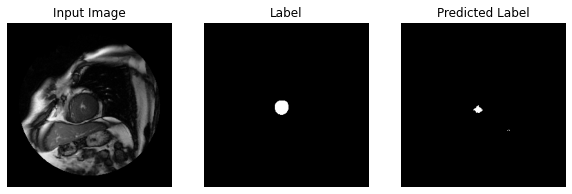


Sample Prediction after epoch 8

234/26 [==============================================================================================================================================================================================================================================================================] - 5s 22ms/step - loss: 0.0077 - dice_coef: 0.8029 - accuracy: 0.9963 - f1_score: 0.9929 - precision: 1.0000 - recall: 0.9858 - val_loss: 0.0126 - val_dice_coef: 0.6921 - val_accuracy: 0.9950 - val_f1_score: 0.9917 - val_precision: 1.0000 - val_recall: 0.9836
Epoch 9/30
25/26 [===========================>..] - ETA: 0s - loss: 0.0096 - dice_coef: 0.7400 - accuracy: 0.9963 - f1_score: 0.9925 - precision: 1.0000 - recall: 0.9851

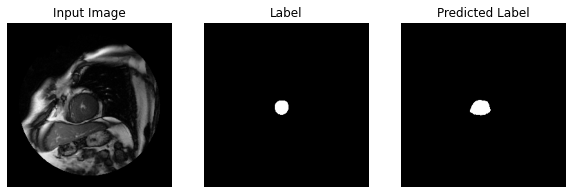


Sample Prediction after epoch 9

234/26 [==============================================================================================================================================================================================================================================================================] - 5s 23ms/step - loss: 0.0096 - dice_coef: 0.8196 - accuracy: 0.9967 - f1_score: 0.9936 - precision: 1.0000 - recall: 0.9872 - val_loss: 0.0101 - val_dice_coef: 0.7922 - val_accuracy: 0.9959 - val_f1_score: 0.9938 - val_precision: 1.0000 - val_recall: 0.9878
Epoch 10/30
23/26 [=========================>....] - ETA: 0s - loss: 0.0099 - dice_coef: 0.7308 - accuracy: 0.9963 - f1_score: 0.9940 - precision: 1.0000 - recall: 0.9882

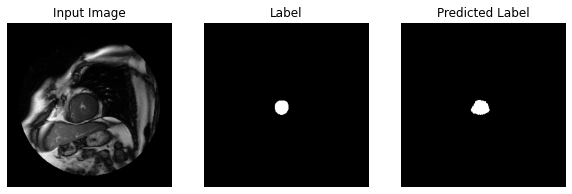


Sample Prediction after epoch 10

234/26 [==============================================================================================================================================================================================================================================================================] - 6s 26ms/step - loss: 0.0075 - dice_coef: 0.8362 - accuracy: 0.9970 - f1_score: 0.9946 - precision: 1.0000 - recall: 0.9893 - val_loss: 0.0089 - val_dice_coef: 0.7889 - val_accuracy: 0.9965 - val_f1_score: 0.9952 - val_precision: 1.0000 - val_recall: 0.9905
Epoch 11/30
23/26 [=========================>....] - ETA: 0s - loss: 0.0077 - dice_coef: 0.7406 - accuracy: 0.9969 - f1_score: 0.9951 - precision: 1.0000 - recall: 0.9902

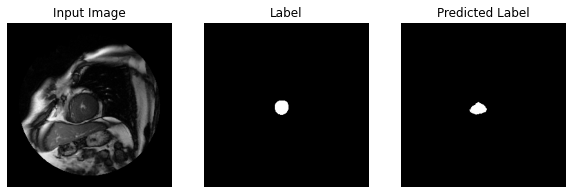


Sample Prediction after epoch 11

234/26 [==============================================================================================================================================================================================================================================================================] - 6s 25ms/step - loss: 0.0054 - dice_coef: 0.8530 - accuracy: 0.9974 - f1_score: 0.9957 - precision: 1.0000 - recall: 0.9914 - val_loss: 0.0084 - val_dice_coef: 0.8017 - val_accuracy: 0.9968 - val_f1_score: 0.9965 - val_precision: 1.0000 - val_recall: 0.9931
Epoch 12/30
24/26 [==========================>...] - ETA: 0s - loss: 0.0057 - dice_coef: 0.8308 - accuracy: 0.9977 - f1_score: 0.9968 - precision: 1.0000 - recall: 0.9936

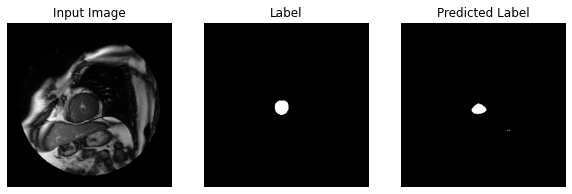


Sample Prediction after epoch 12

234/26 [==============================================================================================================================================================================================================================================================================] - 6s 27ms/step - loss: 0.0051 - dice_coef: 0.8681 - accuracy: 0.9976 - f1_score: 0.9966 - precision: 1.0000 - recall: 0.9932 - val_loss: 0.0084 - val_dice_coef: 0.8098 - val_accuracy: 0.9968 - val_f1_score: 0.9969 - val_precision: 1.0000 - val_recall: 0.9938
Epoch 13/30
24/26 [==========================>...] - ETA: 0s - loss: 0.0052 - dice_coef: 0.8139 - accuracy: 0.9977 - f1_score: 0.9972 - precision: 1.0000 - recall: 0.9944

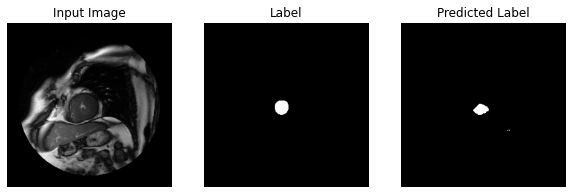


Sample Prediction after epoch 13

234/26 [==============================================================================================================================================================================================================================================================================] - 6s 27ms/step - loss: 0.0058 - dice_coef: 0.8705 - accuracy: 0.9977 - f1_score: 0.9970 - precision: 1.0000 - recall: 0.9941 - val_loss: 0.0090 - val_dice_coef: 0.8032 - val_accuracy: 0.9967 - val_f1_score: 0.9970 - val_precision: 1.0000 - val_recall: 0.9940
Epoch 14/30
24/26 [==========================>...] - ETA: 0s - loss: 0.0057 - dice_coef: 0.8394 - accuracy: 0.9976 - f1_score: 0.9974 - precision: 1.0000 - recall: 0.9949

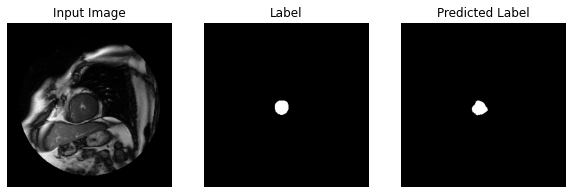


Sample Prediction after epoch 14

234/26 [==============================================================================================================================================================================================================================================================================] - 7s 30ms/step - loss: 0.0046 - dice_coef: 0.8618 - accuracy: 0.9976 - f1_score: 0.9973 - precision: 1.0000 - recall: 0.9946 - val_loss: 0.0083 - val_dice_coef: 0.8019 - val_accuracy: 0.9966 - val_f1_score: 0.9973 - val_precision: 1.0000 - val_recall: 0.9946
Epoch 15/30
25/26 [===========================>..] - ETA: 0s - loss: 0.0051 - dice_coef: 0.8389 - accuracy: 0.9979 - f1_score: 0.9976 - precision: 1.0000 - recall: 0.9953

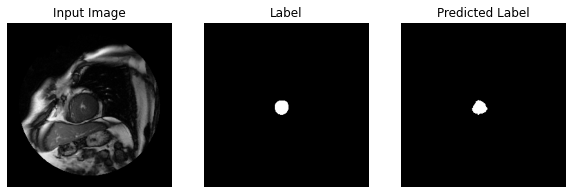


Sample Prediction after epoch 15

234/26 [==============================================================================================================================================================================================================================================================================] - 9s 39ms/step - loss: 0.0056 - dice_coef: 0.8906 - accuracy: 0.9979 - f1_score: 0.9977 - precision: 1.0000 - recall: 0.9954 - val_loss: 0.0098 - val_dice_coef: 0.8142 - val_accuracy: 0.9966 - val_f1_score: 0.9980 - val_precision: 1.0000 - val_recall: 0.9961
Epoch 16/30
23/26 [=========================>....] - ETA: 0s - loss: 0.0062 - dice_coef: 0.8121 - accuracy: 0.9977 - f1_score: 0.9978 - precision: 1.0000 - recall: 0.9956

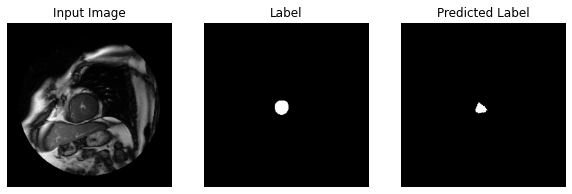


Sample Prediction after epoch 16

234/26 [==============================================================================================================================================================================================================================================================================] - 7s 28ms/step - loss: 0.0062 - dice_coef: 0.8789 - accuracy: 0.9977 - f1_score: 0.9977 - precision: 1.0000 - recall: 0.9953 - val_loss: 0.0075 - val_dice_coef: 0.8305 - val_accuracy: 0.9970 - val_f1_score: 0.9977 - val_precision: 1.0000 - val_recall: 0.9954
Epoch 17/30
25/26 [===========================>..] - ETA: 0s - loss: 0.0054 - dice_coef: 0.8783 - accuracy: 0.9977 - f1_score: 0.9978 - precision: 1.0000 - recall: 0.9956

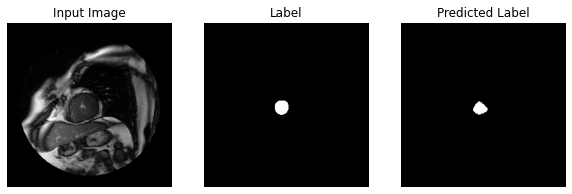


Sample Prediction after epoch 17

234/26 [==============================================================================================================================================================================================================================================================================] - 6s 24ms/step - loss: 0.0051 - dice_coef: 0.8966 - accuracy: 0.9981 - f1_score: 0.9982 - precision: 1.0000 - recall: 0.9963 - val_loss: 0.0076 - val_dice_coef: 0.8214 - val_accuracy: 0.9971 - val_f1_score: 0.9982 - val_precision: 1.0000 - val_recall: 0.9964
Epoch 18/30
25/26 [===========================>..] - ETA: 0s - loss: 0.0040 - dice_coef: 0.8766 - accuracy: 0.9983 - f1_score: 0.9984 - precision: 1.0000 - recall: 0.9967

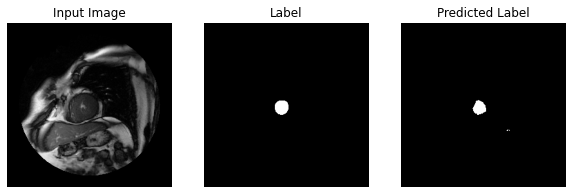


Sample Prediction after epoch 18

234/26 [==============================================================================================================================================================================================================================================================================] - 5s 21ms/step - loss: 0.0047 - dice_coef: 0.8972 - accuracy: 0.9982 - f1_score: 0.9982 - precision: 1.0000 - recall: 0.9965 - val_loss: 0.0080 - val_dice_coef: 0.8254 - val_accuracy: 0.9970 - val_f1_score: 0.9983 - val_precision: 1.0000 - val_recall: 0.9967
Epoch 19/30
25/26 [===========================>..] - ETA: 0s - loss: 0.0038 - dice_coef: 0.8823 - accuracy: 0.9984 - f1_score: 0.9985 - precision: 1.0000 - recall: 0.9970

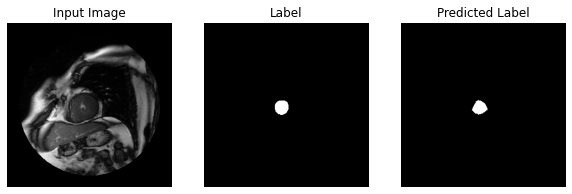


Sample Prediction after epoch 19

234/26 [==============================================================================================================================================================================================================================================================================] - 6s 25ms/step - loss: 0.0043 - dice_coef: 0.9110 - accuracy: 0.9984 - f1_score: 0.9985 - precision: 1.0000 - recall: 0.9971 - val_loss: 0.0080 - val_dice_coef: 0.8334 - val_accuracy: 0.9972 - val_f1_score: 0.9985 - val_precision: 1.0000 - val_recall: 0.9971
Epoch 20/30
24/26 [==========================>...] - ETA: 0s - loss: 0.0036 - dice_coef: 0.8860 - accuracy: 0.9985 - f1_score: 0.9986 - precision: 1.0000 - recall: 0.9972

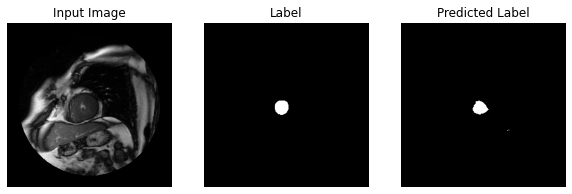


Sample Prediction after epoch 20

234/26 [==============================================================================================================================================================================================================================================================================] - 7s 31ms/step - loss: 0.0038 - dice_coef: 0.9092 - accuracy: 0.9983 - f1_score: 0.9985 - precision: 1.0000 - recall: 0.9970 - val_loss: 0.0072 - val_dice_coef: 0.8357 - val_accuracy: 0.9972 - val_f1_score: 0.9984 - val_precision: 1.0000 - val_recall: 0.9968
Epoch 21/30
25/26 [===========================>..] - ETA: 0s - loss: 0.0037 - dice_coef: 0.8498 - accuracy: 0.9984 - f1_score: 0.9987 - precision: 1.0000 - recall: 0.9973

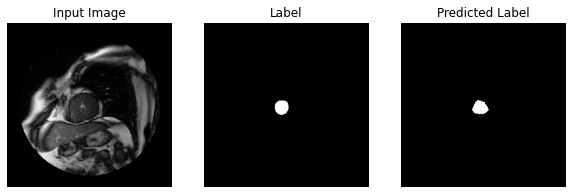


Sample Prediction after epoch 21

234/26 [==============================================================================================================================================================================================================================================================================] - 6s 26ms/step - loss: 0.0040 - dice_coef: 0.9087 - accuracy: 0.9984 - f1_score: 0.9987 - precision: 1.0000 - recall: 0.9973 - val_loss: 0.0072 - val_dice_coef: 0.8416 - val_accuracy: 0.9974 - val_f1_score: 0.9987 - val_precision: 1.0000 - val_recall: 0.9975
Epoch 22/30
25/26 [===========================>..] - ETA: 0s - loss: 0.0048 - dice_coef: 0.8619 - accuracy: 0.9980 - f1_score: 0.9984 - precision: 1.0000 - recall: 0.9967

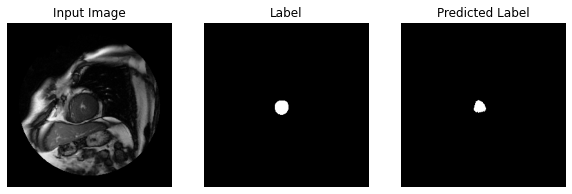


Sample Prediction after epoch 22

234/26 [==============================================================================================================================================================================================================================================================================] - 7s 28ms/step - loss: 0.0052 - dice_coef: 0.9116 - accuracy: 0.9984 - f1_score: 0.9987 - precision: 1.0000 - recall: 0.9974 - val_loss: 0.0081 - val_dice_coef: 0.8333 - val_accuracy: 0.9971 - val_f1_score: 0.9987 - val_precision: 1.0000 - val_recall: 0.9974
Epoch 23/30
25/26 [===========================>..] - ETA: 0s - loss: 0.0040 - dice_coef: 0.8549 - accuracy: 0.9982 - f1_score: 0.9985 - precision: 1.0000 - recall: 0.9971

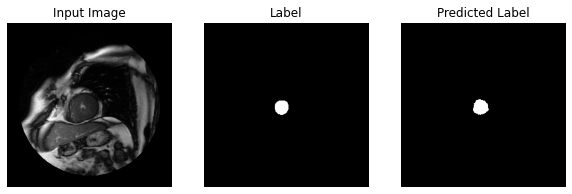


Sample Prediction after epoch 23

234/26 [==============================================================================================================================================================================================================================================================================] - 6s 24ms/step - loss: 0.0033 - dice_coef: 0.9157 - accuracy: 0.9984 - f1_score: 0.9987 - precision: 1.0000 - recall: 0.9973 - val_loss: 0.0091 - val_dice_coef: 0.8214 - val_accuracy: 0.9969 - val_f1_score: 0.9988 - val_precision: 1.0000 - val_recall: 0.9976
Epoch 24/30
23/26 [=========================>....] - ETA: 0s - loss: 0.0034 - dice_coef: 0.8872 - accuracy: 0.9985 - f1_score: 0.9989 - precision: 1.0000 - recall: 0.9978

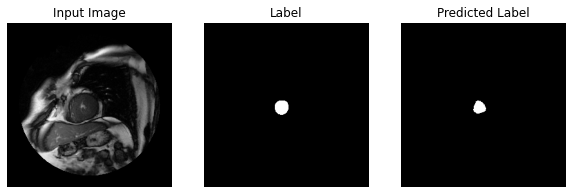


Sample Prediction after epoch 24

234/26 [==============================================================================================================================================================================================================================================================================] - 6s 27ms/step - loss: 0.0030 - dice_coef: 0.9171 - accuracy: 0.9985 - f1_score: 0.9988 - precision: 1.0000 - recall: 0.9976 - val_loss: 0.0082 - val_dice_coef: 0.8382 - val_accuracy: 0.9974 - val_f1_score: 0.9989 - val_precision: 1.0000 - val_recall: 0.9977
Epoch 25/30
25/26 [===========================>..] - ETA: 0s - loss: 0.0033 - dice_coef: 0.9157 - accuracy: 0.9986 - f1_score: 0.9990 - precision: 1.0000 - recall: 0.9979

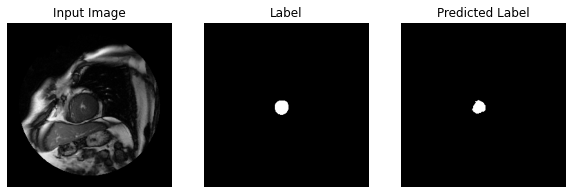


Sample Prediction after epoch 25

234/26 [==============================================================================================================================================================================================================================================================================] - 7s 29ms/step - loss: 0.0030 - dice_coef: 0.9252 - accuracy: 0.9986 - f1_score: 0.9989 - precision: 1.0000 - recall: 0.9979 - val_loss: 0.0081 - val_dice_coef: 0.8405 - val_accuracy: 0.9974 - val_f1_score: 0.9990 - val_precision: 1.0000 - val_recall: 0.9979
Epoch 26/30
25/26 [===========================>..] - ETA: 0s - loss: 0.0030 - dice_coef: 0.9077 - accuracy: 0.9988 - f1_score: 0.9991 - precision: 1.0000 - recall: 0.9982

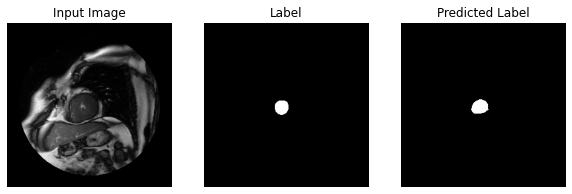


Sample Prediction after epoch 26

234/26 [==============================================================================================================================================================================================================================================================================] - 6s 27ms/step - loss: 0.0039 - dice_coef: 0.9254 - accuracy: 0.9986 - f1_score: 0.9990 - precision: 1.0000 - recall: 0.9980 - val_loss: 0.0104 - val_dice_coef: 0.8216 - val_accuracy: 0.9966 - val_f1_score: 0.9988 - val_precision: 1.0000 - val_recall: 0.9977
Epoch 27/30
24/26 [==========================>...] - ETA: 0s - loss: 0.0038 - dice_coef: 0.9362 - accuracy: 0.9984 - f1_score: 0.9989 - precision: 1.0000 - recall: 0.9977

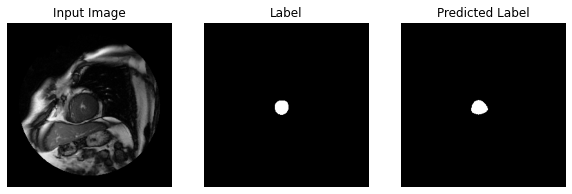


Sample Prediction after epoch 27

234/26 [==============================================================================================================================================================================================================================================================================] - 14s 60ms/step - loss: 0.0045 - dice_coef: 0.9206 - accuracy: 0.9985 - f1_score: 0.9989 - precision: 1.0000 - recall: 0.9978 - val_loss: 0.0097 - val_dice_coef: 0.8134 - val_accuracy: 0.9964 - val_f1_score: 0.9984 - val_precision: 1.0000 - val_recall: 0.9968
Epoch 28/30
24/26 [==========================>...] - ETA: 0s - loss: 0.0042 - dice_coef: 0.9227 - accuracy: 0.9982 - f1_score: 0.9987 - precision: 1.0000 - recall: 0.9975

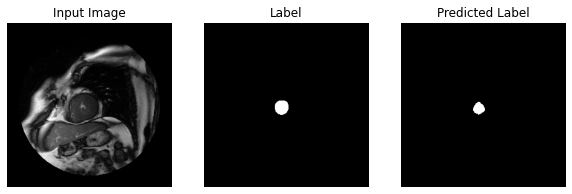


Sample Prediction after epoch 28

234/26 [==============================================================================================================================================================================================================================================================================] - 6s 27ms/step - loss: 0.0043 - dice_coef: 0.8869 - accuracy: 0.9979 - f1_score: 0.9984 - precision: 1.0000 - recall: 0.9968 - val_loss: 0.0148 - val_dice_coef: 0.7942 - val_accuracy: 0.9967 - val_f1_score: 0.9987 - val_precision: 1.0000 - val_recall: 0.9974
Epoch 29/30
25/26 [===========================>..] - ETA: 0s - loss: 0.0034 - dice_coef: 0.8855 - accuracy: 0.9985 - f1_score: 0.9989 - precision: 1.0000 - recall: 0.9977

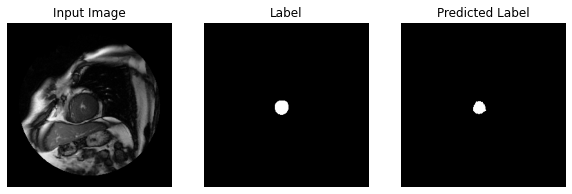


Sample Prediction after epoch 29

234/26 [==============================================================================================================================================================================================================================================================================] - 6s 24ms/step - loss: 0.0033 - dice_coef: 0.9262 - accuracy: 0.9986 - f1_score: 0.9989 - precision: 1.0000 - recall: 0.9978 - val_loss: 0.0127 - val_dice_coef: 0.8084 - val_accuracy: 0.9968 - val_f1_score: 0.9989 - val_precision: 1.0000 - val_recall: 0.9978
Epoch 30/30
24/26 [==========================>...] - ETA: 0s - loss: 0.0026 - dice_coef: 0.8992 - accuracy: 0.9989 - f1_score: 0.9990 - precision: 1.0000 - recall: 0.9980

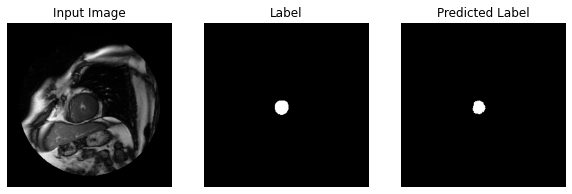


Sample Prediction after epoch 30


234/26 [==============================================================================================================================================================================================================================================================================] - 5s 22ms/step - loss: 0.0032 - dice_coef: 0.9310 - accuracy: 0.9988 - f1_score: 0.9991 - precision: 1.0000 - recall: 0.9981 - val_loss: 0.0099 - val_dice_coef: 0.8270 - val_accuracy: 0.9971 - val_f1_score: 0.9991 - val_precision: 1.0000 - val_recall: 0.9982


In [52]:
EPOCHS = 30
STEPS_PER_EPOCH = len(list(parsed_training_dataset))

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

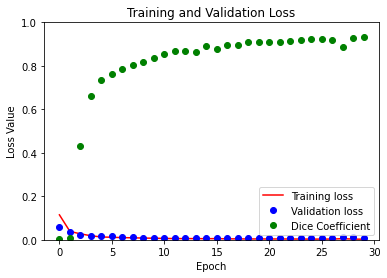

In [53]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']
dice = model_history.history['dice_coef']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.plot(epochs, dice, 'go', label='Dice Coefficient')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()


### TensorBoard
We can also see these results in TensorBoard. To use [TensorBoard in a notebook](https://www.tensorflow.org/tensorboard/tensorboard_in_notebooks), we'll first need to load the TensorBoard extension.

In [54]:
%load_ext tensorboard

In [55]:
%tensorboard --logdir logs

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 7372.

In [56]:
from tensorboard import notebook

In [57]:
notebook.display(port=6006, height=1000) 

Selecting TensorBoard with logdir logs (started 0:00:40 ago; port 6006, pid 11868).


![workflow](readme/tensorboard_execution.png)
